# Imports etc.

In [19]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame


from utils import get_mask
from main import train

from psd import power_spectrum_error

# Plotting Setup
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
TS = 16
LS = 14

# Prelimiary Visualization

In [3]:
lorenz63 = np.load("./data/lorenz63_test.npy")
lorenz96 = np.load("./data/lorenz96_test.npy")

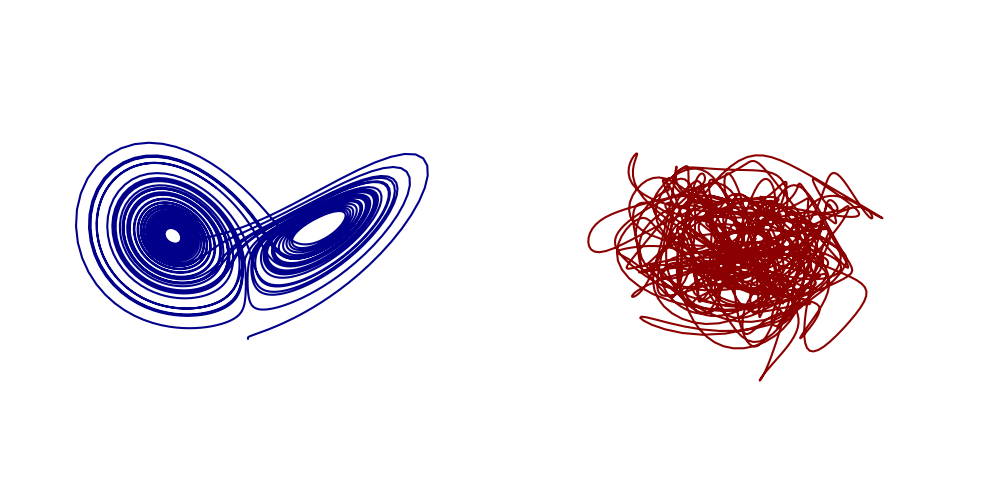

In [4]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122, projection="3d")
ax1.set_axis_off()
ax2.set_axis_off()
ax1.plot(lorenz63[:5000,0], lorenz63[:5000,1], lorenz63[:5000,2], lw=1.5, color="darkblue")
ax2.plot(lorenz96[:5000,0], lorenz96[:5000,1], lorenz96[:5000,3], lw=1.5, color="darkred")

plt.tight_layout()

# Implementation of T-step ahead prediction and powerspectrum evaluation

In [5]:
def T_step_prediction(
    model: nn.Module, initial_enc_input: Tensor, initial_dec_input: Tensor, enc_mask: Tensor, dec_mask: Tensor, T: int
) -> Tensor:
    if len(initial_enc_input.shape) < 3:
        initial_enc_input.unsqueeze(0)
    if len(initial_dec_input.shape) < 3:
        initial_dec_input.unsqueeze(0)

    prediction = initial_dec_input

    enc_input = initial_enc_input
    dec_input = initial_dec_input

    for t in range(T):
        with torch.no_grad():
            dec_output = model(enc_input, dec_input, enc_mask, dec_mask)
        enc_input = torch.cat((enc_input[:, 1:, :], dec_output), dim=1)
        dec_input = dec_output
        prediction = torch.cat((prediction, dec_output), dim=1)

    return prediction


def compare_spectra(model: nn.Module, test_data: ndarray, enc_seq_len: int, dec_seq_len: int, sigma: float):
    if len(test_data.shape) < 3:
        test_data = test_data[None, :, :]

    initial_enc_input = torch.zeros((1, enc_seq_len, test_data.shape[-1]))
    initital_dec_input = torch.randn((1, 1, test_data.shape[-1]))
    enc_mask = get_mask((dec_seq_len, enc_seq_len))
    dec_mask = get_mask((dec_seq_len, dec_seq_len))

    prediction = T_step_prediction(
        model, initial_enc_input, initital_dec_input, enc_mask, dec_mask, test_data.shape[1]
    )

    prediction = prediction[:, 1:, :].numpy()

    ps_error = power_spectrum_error(prediction, test_data, sigma=sigma)

    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(221, projection="3d")
    prediction = prediction.squeeze()
    ax1.plot(prediction[:, 0], prediction[:, 1], prediction[:, 2], color="red", label="Generated Trajectory")
    ax1.set_title("Generated Trajectory", fontsize=TS)
    ax2 = fig.add_subplot(222, projection="3d")
    test_data = test_data.squeeze()
    ax2.plot(test_data[:, 0], test_data[:, 1], test_data[:, 2], color="blue", label="True Trajectory")
    ax2.set_title("True Trajectory", fontsize=TS)
    ax3 = fig.add_subplot(212)
    ax3.plot(ps_error[1].squeeze(), color="blue", label="True Spectrum")
    ax3.plot(ps_error[2].squeeze(), color="red", label="Generated Spectrum")
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    #ax3.set_ylim([1e-5, 1])
    ax3.legend(frameon=False, fontsize=LS)
    ax3.set_title("Powerspectra", fontsize=TS)
    plt.tight_layout()

    return prediction, ps_error

# Lorenz 63

In [6]:
lorenz63_model = torch.load("./models/full_lorenz63.pt")
lorenz63_model_half = torch.load("./models/half_lorenz63.pt")

In [75]:
lorenz63_model = train(
    "../lorenz63_on0.05_train.npy",
    enc_seq_len=7,
    target_seq_len=1,
    d_obs=3,
    d_model=32,
    num_heads=2,
    enc_num_layers=2,
    dec_num_layers=2,
    num_epochs=0,
    batchsize=512,
    learning_rate={
        0: 1e-4,
        1: 1e-5,
        3: 1e-6,
    },
    enc_dropout=0.4,
    dec_dropout=0.4,
)
torch.save(lorenz63_model, f"./models/lorenz63_{datetime.now()}.pt")

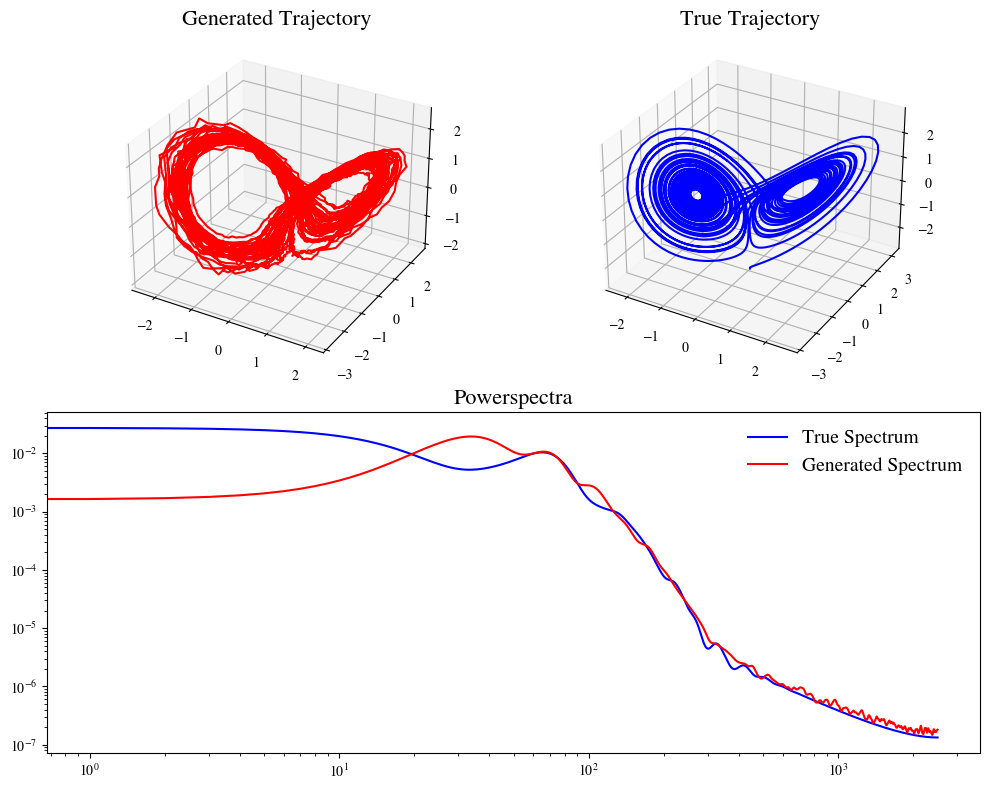

In [7]:
lorenz63_prediction, lorenz63_ps_error = compare_spectra(model=lorenz63_model, test_data=lorenz63[:5000], enc_seq_len=7, dec_seq_len=1, sigma=10)

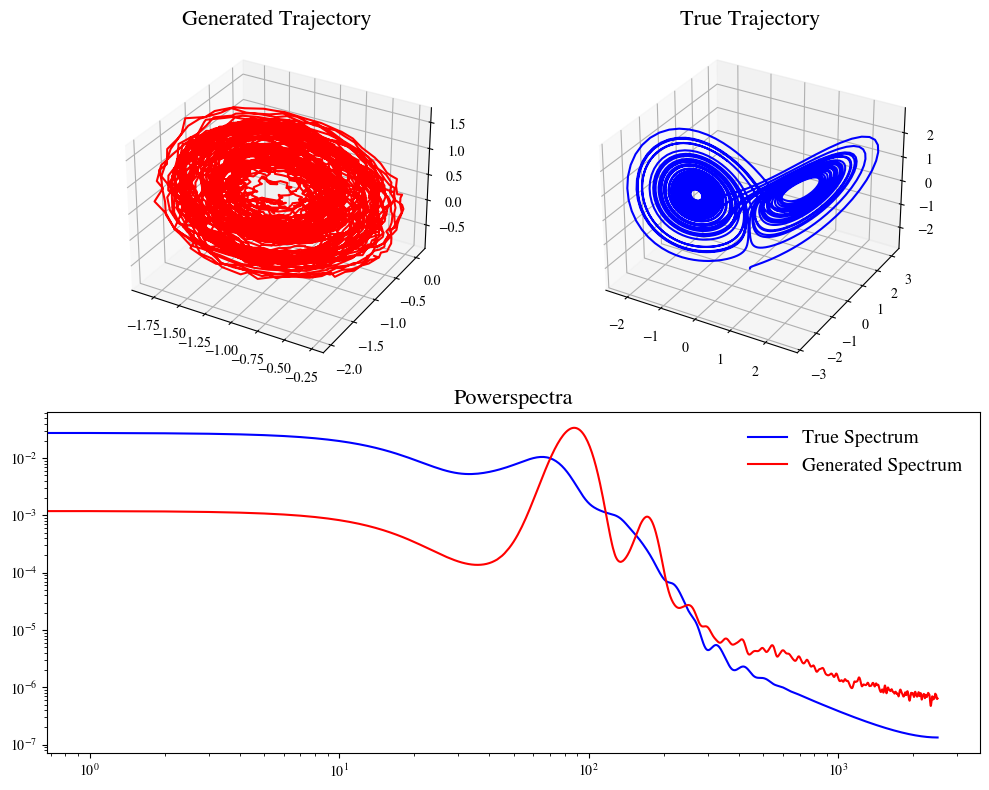

In [8]:
lorenz63_half_prediction, lorenz63_half_ps_error = compare_spectra(model=lorenz63_model_half, test_data=lorenz63[:5000], enc_seq_len=7, dec_seq_len=1, sigma=10)

# Lorenz 96

In [11]:
lorenz96_model = torch.load("./models/lorenz96.pt")

In [ ]:
lorenz96_model = train(
    "../lorenz96_on0.05_train.npy",
    enc_seq_len=7,
    target_seq_len=1,
    d_obs=20,
    d_model=128,
    num_heads=2,
    enc_num_layers=2,
    dec_num_layers=2,
    num_epochs=10,
    batchsize=512,
    learning_rate={
        0: 1e-3,
        1: 1e-4,
        3: 1e-5,
    },
    enc_dropout=0.4,
    dec_dropout=0.4,
)
torch.save(lorenz96_model, f"./models/lorenz96_{datetime.now()}.pt")

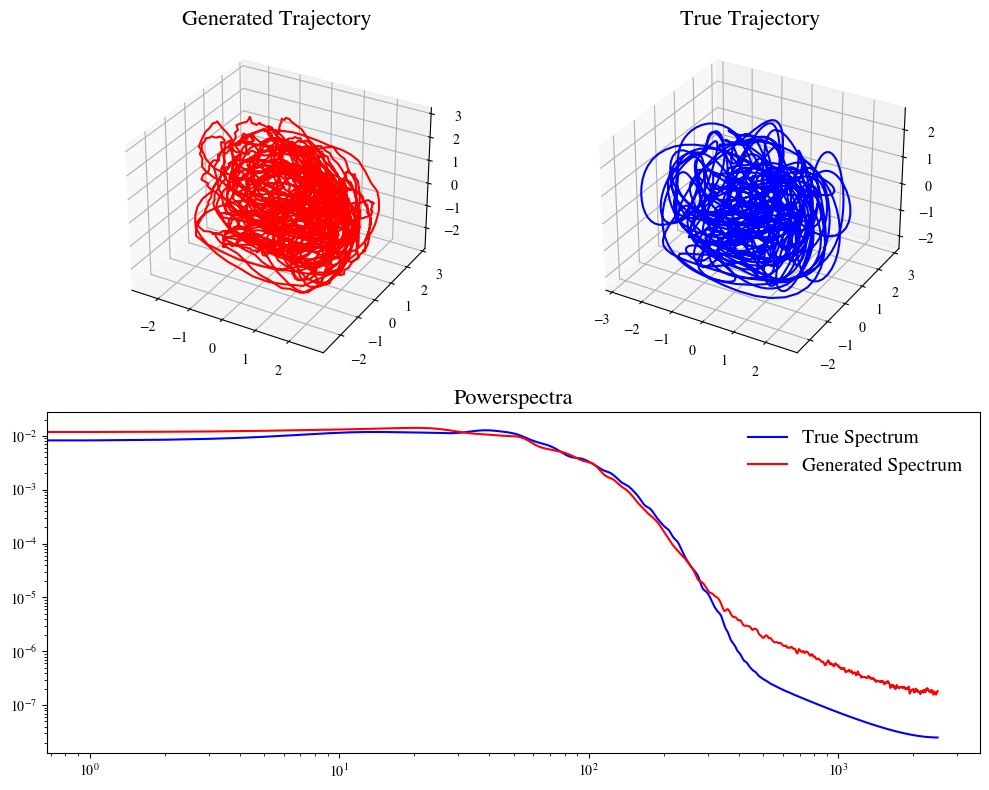

In [12]:
lorenz96_prediction, lorenz96_ps_error = compare_spectra(model=lorenz96_model, test_data=lorenz96[:5000], enc_seq_len=7, dec_seq_len=1, sigma=5)

# Summary

In [20]:
DataFrame(
    {"Powerspectrum Error": [lorenz63_ps_error[0], lorenz63_half_ps_error[0], lorenz96_ps_error[0]]},
    index = ["Lorenz 63", "Lorenz 63 (Half)", "Lorenz 96"]
)

,Powerspectrum Error
Lorenz 63,0.331366
Lorenz 63 (Half),0.637319
Lorenz 96,0.119841
